# Book Recommendation System

## Idea
We will make a book recommendation system based in the user's last read books. Our final objective is to recommend 10 books for each person. For this, we first make PCA (Principal Component Analysks) and then clusterize the books using K-Means. The clusters are created considering some characteristics:

- Year of Publication
- Mean Age of Readers by Book
- Mean Age of Readers by Author
- Mean Age of Readers by Publisher
- Mean Rating by Book
- Mean Rating by Author
- Mean Rating by Publisher
- Top Location by Book (Count Encoded) - where the book has been more read.
- Book Contribution to Top Location - what is the fraction of readings the book contributed to in its top place.
- Book Author (Count Encoded)
- Publisher (Count Encoded)
- Book Appearances (Count encoding of ISBN)

After that, we recommend books from the clusters which have a book that the person has already read. In this context, using bootstrap, we randomly select the next book that was read so we can select another book from the same cluster as it. This selection is done with K-Nearest Neighbors: we calculate the nearest neighbors from the same cluster and then select one of them to compose the recommendations - the additional condition is that the book must not have been recommended yet. The number of nearest neighbors will be determined by the length of the already read books, to guarantee that we will have sufficient neighbors to look for a new book to recommend.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import CountEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import random

## Importing Data

In [2]:
books = pd.read_csv("data/books.csv", sep=";", encoding="latin-1", low_memory=False, on_bad_lines='skip').drop(["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1)
ratings = pd.read_csv("data/ratings.csv", sep=";", encoding="latin-1", low_memory=False, on_bad_lines='skip')
users = pd.read_csv("data/users.csv", sep=";", encoding="latin-1", low_memory=False, on_bad_lines='skip')

## Cleaning Data

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [4]:
books[books["Book-Author"].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [5]:
books[books["Publisher"].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [6]:
books = books.dropna()

---

In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


---

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [9]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [10]:
users["Age"] = users["Age"].fillna(users["Age"].median())

---

In [11]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [12]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [13]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",32.0
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",32.0
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",32.0


## Merging Dataframes

In [14]:
users_ratings = pd.merge(users, ratings, on="User-ID", how="inner")
books_users_ratings = pd.merge(books, users_ratings, on="ISBN", how="inner")
df_main = books_users_ratings.copy()
df_users = books_users_ratings.copy()

In [15]:
df_main.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Location,Age,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,"stockton, california, usa",18.0,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,"timmins, ontario, canada",32.0,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,"ottawa, ontario, canada",49.0,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,"n/a, n/a, n/a",32.0,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385,"sudbury, ontario, canada",32.0,0


---

## Data Preprocessing

In [16]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031132 entries, 0 to 1031131
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ISBN                 1031132 non-null  object 
 1   Book-Title           1031132 non-null  object 
 2   Book-Author          1031132 non-null  object 
 3   Year-Of-Publication  1031132 non-null  object 
 4   Publisher            1031132 non-null  object 
 5   User-ID              1031132 non-null  int64  
 6   Location             1031132 non-null  object 
 7   Age                  1031132 non-null  float64
 8   Book-Rating          1031132 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 70.8+ MB


In [17]:
df_main.describe()

,User-ID,Age,Book-Rating
count,1.031132e+06,1.031132e+06,1.031132e+06
mean,1.405947e+05,3.594326e+01,2.839027e+00
std,8.052475e+04,1.228578e+01,3.854145e+00
min,2.000000e+00,0.000000e+00,0.000000e+00
25%,7.041500e+04,3.100000e+01,0.000000e+00
50%,1.412100e+05,3.200000e+01,0.000000e+00
75%,2.114260e+05,4.100000e+01,7.000000e+00
max,2.788540e+05,2.440000e+02,1.000000e+01


### Dropping Strange Ages

Some years are greater than 100 (some are even greater than 200, which is worse). So, we will limit the user age to be less than 100.

In [18]:
df_main = df_main[df_main["Age"] < 100]

### Dropping Strange Years Of Publication and Converting to Int

Some years of publication are not numerical. Besides, some of them are greater than 2004, which is really strange, since the data was collected in 2004.

In [19]:
df_main = df_main[df_main["Year-Of-Publication"].str.isnumeric()]
df_main["Year-Of-Publication"] = df_main["Year-Of-Publication"].apply(lambda x: int(x))
df_main = df_main[df_main["Year-Of-Publication"] <= 2004]

### Mean Ages and Ratings

Now, we will start getting our features.

In [20]:
mean_age_by_book = df_main.groupby("Book-Title")["Age"].mean().rename("Mean-Age-By-Book")
df_main = pd.merge(df_main, mean_age_by_book, on="Book-Title", how="inner")

In [21]:
mean_age_by_author = df_main.groupby("Book-Author")["Age"].mean().rename("Mean-Age-By-Author")
df_main = pd.merge(df_main, mean_age_by_author, on="Book-Author", how="inner")

In [22]:
mean_age_by_publisher = df_main.groupby("Publisher")["Age"].mean().rename("Mean-Age-By-Publisher")
df_main = pd.merge(df_main, mean_age_by_publisher, on="Publisher", how="inner")

In [23]:
mean_rating_by_book = df_main.groupby("Book-Title")["Book-Rating"].mean().rename("Mean-Rating-By-Book")
df_main = pd.merge(df_main, mean_rating_by_book, on="Book-Title", how="inner")

In [24]:
mean_rating_by_author = df_main.groupby("Book-Author")["Book-Rating"].mean().rename("Mean-Rating-By-Author")
df_main = pd.merge(df_main, mean_rating_by_author, on="Book-Author", how="inner")

In [25]:
mean_rating_by_publisher = df_main.groupby("Publisher")["Book-Rating"].mean().rename("Mean-Rating-By-Publisher")
df_main = pd.merge(df_main, mean_rating_by_publisher, on="Publisher", how="inner")

In [26]:
df_main = df_main.drop(["Age", "Book-Rating", "User-ID"], axis=1)

### Top Location By Book

In [27]:
location_count_by_book = df_main.groupby(["ISBN", "Location"]).size().reset_index(name="Readers-Count-In-Top-Location")
top_location_by_book = location_count_by_book.loc[location_count_by_book.groupby("ISBN")["Readers-Count-In-Top-Location"].idxmax()].rename({"Location": "Top-Location-By-Book"}, axis=1)
df_main = pd.merge(df_main, top_location_by_book, on="ISBN", how="inner")

### Count Encodings

In [28]:
location_encoder = CountEncoder()
df_main["Location-Encoded"] = location_encoder.fit_transform(df_main["Location"])

In [29]:
location_encodings = df_main.groupby(["Location"])["Location-Encoded"].max().rename("Top-Location-By-Book-Encoded")
df_main = df_main.drop(["Location-Encoded"], axis=1)
df_main = pd.merge(df_main, location_encodings, left_on="Top-Location-By-Book", right_on="Location", how="inner")

In [30]:
df_main = df_main.drop(["Location", "Top-Location-By-Book"], axis=1)

In [31]:
author_encoder = CountEncoder()
df_main["Book-Author-Encoded"] = author_encoder.fit_transform(df_main["Book-Author"])
df_main = df_main.drop(["Book-Author"], axis=1)

In [32]:
publisher_encoder = CountEncoder()
df_main["Publisher-Encoded"] = publisher_encoder.fit_transform(df_main["Publisher"])
df_main = df_main.drop(["Publisher"], axis=1)

### Book Contribution to Top Location

In [33]:
df_main["Book-Contribution-To-Top-Location"] = df_main["Readers-Count-In-Top-Location"]/df_main["Top-Location-By-Book-Encoded"]

df_main = df_main.drop(["Readers-Count-In-Top-Location"], axis=1)

### Book Appearances

In [34]:
isbn_encoder = CountEncoder()
df_main["Book-Appearances"] = isbn_encoder.fit_transform(df_main["ISBN"])

### Dropping duplicates

In [35]:
df_main = df_main.drop_duplicates()

In [36]:
df_main.head()

,ISBN,Book-Title,Year-Of-Publication,Mean-Age-By-Book,Mean-Age-By-Author,Mean-Age-By-Publisher,Mean-Rating-By-Book,Mean-Rating-By-Author,Mean-Rating-By-Publisher,Top-Location-By-Book-Encoded,Book-Author-Encoded,Publisher-Encoded,Book-Contribution-To-Top-Location,Book-Appearances
0,0195153448,Classical Mythology,2002,24.000,24.000000,34.560567,3.500,3.500000,3.497999,245,2,2749,0.004082,1
1,0764500546,Macs for Teachers (For Dummies Series),1996,28.500,28.500000,36.125796,5.000,5.000000,3.358280,245,2,628,0.004082,1
2,0060907924,A People's History of the United States,1980,52.000,31.305085,37.556155,10.000,3.644068,2.628631,245,59,6678,0.004082,1
3,0425173305,Slackjaw,2000,32.875,33.357143,36.669553,4.625,5.071429,2.430069,245,14,28528,0.004082,3
6,0345391497,The Demon Awakens,1997,32.000,30.411765,36.056426,0.000,3.300654,2.805559,245,306,34612,0.004082,1


### Scaling Data

In the future, we will use PCA (Principal Component Analysis). It's necessary to center the data in the origin (although the Sklearn's PCA do it already) to make the PCA algorithm work right. So, we will make a StandardScale. 

In [37]:
X = df_main.drop(["ISBN", 'Book-Title'], axis=1)

In [38]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [39]:
len(X.columns)

12

## Analysing Multicolinearity

The results can be negatively impacted by the multicollinearity of features used in clustering as the correlated feature will carry extra weight on the distance calculation than desired, in the case of K-means. Let's view the correlations matrix:

<Axes: >

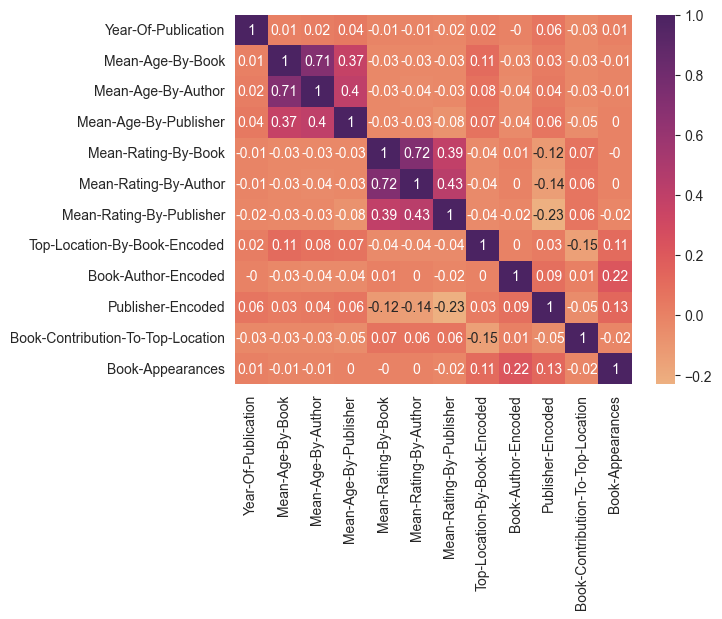

In [40]:
sns.heatmap(X.corr().apply(lambda x: round(x,2)), cmap="flare", annot=True)

## PCA (Principal Component Analysis)

PCA is a good way of eliminating multicollinearity while selecting how much of the variance we want to keep. The trade-off is that PCA makes our dataset less interpretable.

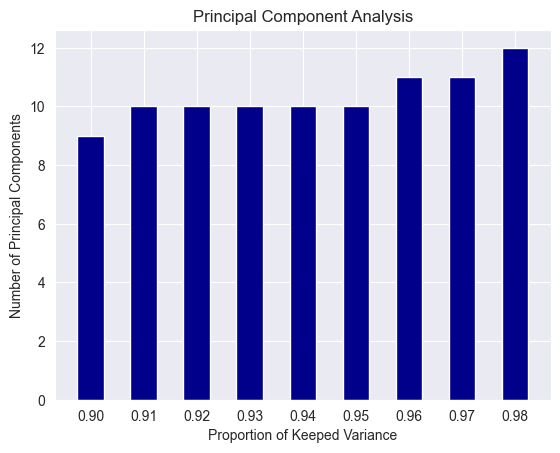

In [41]:
pca = PCA()
pca.fit(X)
variances = np.arange(0.90, 0.99, 0.01)
ds = []
cumsum = np.cumsum(pca.explained_variance_ratio_)
for variance in variances:
    ds.append(np.argmax(cumsum >= variance) + 1) 
plt.bar(height=ds, x=variances, width=0.005, color="darkblue")
plt.xticks(variances)
plt.title("Principal Component Analysis")
plt.xlabel("Proportion of Keeped Variance")
plt.ylabel("Number of Principal Components")
plt.show()

Let's maintain 0.95 (95%) of the variance by choosing 10 components:

In [42]:
pca = PCA(n_components=0.95)
X_reduced_pca = pd.DataFrame(pca.fit_transform(X))
print(f"Number of features (principal components) after PCA: {len(X_reduced_pca.columns)}")

Number of features (principal components) after PCA: 10


In [43]:
X_reduced_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.696502,-1.443178,-0.351310,-0.306430,-0.389128,-0.188699,-0.284555,0.405534,-0.589498,-0.367191
1,-1.715398,-0.277148,-0.293432,-0.214189,-0.374927,-0.273142,-0.360164,0.401790,-0.782221,0.078911
2,-0.659231,1.527538,0.096818,0.266092,-0.549043,-0.982401,-0.205174,0.009632,-0.247342,0.903313
3,-0.166777,-0.176902,0.936386,0.462700,-1.422240,-2.474434,0.619445,-0.063897,-0.029494,-0.317925
4,0.682848,-1.316077,0.990347,0.646928,-1.376340,-2.371907,0.483848,-0.331989,0.325787,-1.440039


Now, let's see the correlations heatmap again. All the components should be orthogonal (correlations = 0).

<Axes: >

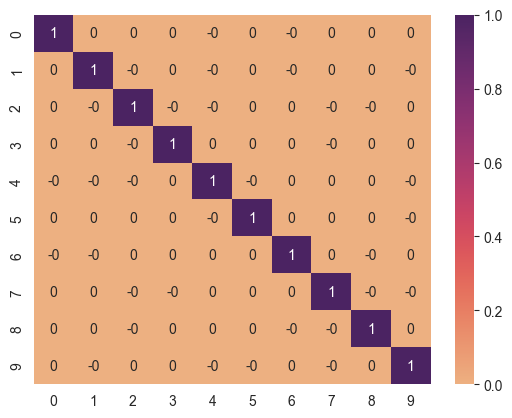

In [44]:
sns.heatmap(X_reduced_pca.corr().apply(lambda x: round(x,2)), cmap="flare", annot=True)

## K-means Clustering

To define the optimal number of clusters, we will first try to use the Elbow Method.
Note: WCSS means Within-Cluster Sum of Squares.

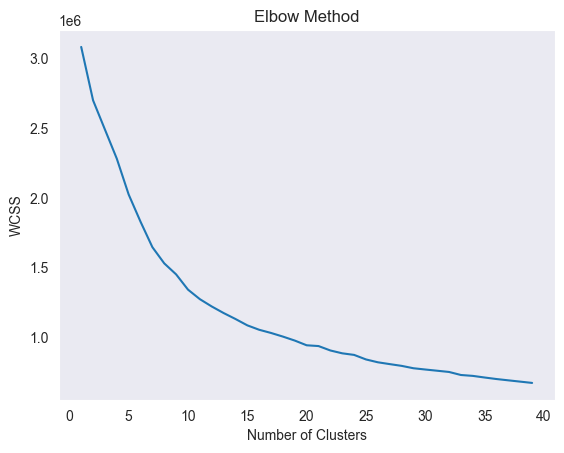

In [45]:
wcss = []
clusters_range = range(1, 40)
for i in clusters_range:
    kmeans = KMeans(n_clusters=i, n_init=1, random_state=0)
    kmeans.fit(X_reduced_pca)
    wcss.append(kmeans.inertia_)

plt.plot(clusters_range, wcss)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid()
plt.show()

The elbow isn't so clear. Another option is to use the Silhouette Analysis, which measures the silhouette coefficient for each point and finally takes it means. The silhouette coefficient is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation). The greater the coefficient is, the best.

However, we will try to use, for example, 15 clusters from the elbow method because the silhouette analysis may last so much, due to the big number of points we have in the dataset.

In [46]:
kmeans = KMeans(n_clusters=15, n_init=1, random_state=0).fit(X_reduced_pca)
df_books = X_reduced_pca.copy()
df_books["Cluster"] = kmeans.labels_
df_books["ISBN"] = df_main["ISBN"].reset_index(drop=True).copy()
df_books["Book-Title"] = df_main["Book-Title"].reset_index(drop=True).copy()

In [47]:
df_books["Cluster"].value_counts()

Cluster
13    54348
0     50919
10    34119
2     32904
1     26724
9     20954
11    17512
8     12783
6      5518
3      4464
4      3277
12     2832
7      1992
5      1247
14      139
Name: count, dtype: int64

The number of members of each cluster seems good. Now, we have each book labeled with it cluster:

In [48]:
df_books.head(12)

,0,1,2,3,4,5,6,7,8,9,Cluster,ISBN,Book-Title
0,-1.696502,-1.443178,-0.351310,-0.306430,-0.389128,-0.188699,-0.284555,0.405534,-0.589498,-0.367191,10,0195153448,Classical Mythology
1,-1.715398,-0.277148,-0.293432,-0.214189,-0.374927,-0.273142,-0.360164,0.401790,-0.782221,0.078911,1,0764500546,Macs for Teachers (For Dummies Series)
2,-0.659231,1.527538,0.096818,0.266092,-0.549043,-0.982401,-0.205174,0.009632,-0.247342,0.903313,8,0060907924,A People's History of the United States
3,-0.166777,-0.176902,0.936386,0.462700,-1.422240,-2.474434,0.619445,-0.063897,-0.029494,-0.317925,2,0425173305,Slackjaw
4,0.682848,-1.316077,0.990347,0.646928,-1.376340,-2.371907,0.483848,-0.331989,0.325787,-1.440039,2,0345391497,The Demon Awakens
5,-1.303070,0.841044,-0.032642,0.152628,-0.372385,-0.420457,-0.525595,-0.011900,-0.291581,1.138972,1,0743508149,"D-Day : June 6, 1944 -- The Climactic Battle o..."
6,-0.514903,0.473079,0.268679,0.301875,-0.866660,-1.522439,0.072950,0.033826,-0.622020,0.660861,13,0449239462,Gabriel Hounds
7,0.150699,-0.253466,-0.484098,0.159279,-0.337027,-0.239497,-0.424973,0.322049,-0.621803,0.494942,0,1575667525,Requiem for a Mezzo: A Daisy Dalrymple Mystery
8,1.309149,-1.355272,0.339593,0.562066,-1.079643,-1.777200,0.300898,-0.122432,-0.006991,-0.241063,2,0373834470,Talisman Ring
9,-0.064785,0.161703,-0.701465,0.055368,-0.100424,0.285778,-0.622898,0.535120,-0.223485,-0.380725,13,0871319705,Private Heat


---

## Recommendation System

We will first get the books each user has already read.

In [49]:
df_users = pd.merge(df_users, df_books[["ISBN", "Cluster"]], on="ISBN", how="inner")
df_users = df_users[["User-ID", "ISBN", "Cluster"]]

In [50]:
df_users_already_read = df_users.groupby("User-ID")["ISBN"].value_counts()
df_users_already_read = pd.DataFrame(df_users_already_read.index.to_list(), columns=["User-ID", "Already-Read-ISBN"])
df_users_already_read.head(12)

,User-ID,Already-Read-ISBN
0,2,0195153448
1,8,0002005018
2,8,0060973129
3,8,0374157065
4,8,0393045218
5,8,0399135782
6,8,0425176428
7,8,0671870432
8,8,0679425608
9,8,074322678X


Now, we need a K-Nearest Neighbors algorithm that receives the isbn and the number of neighbors (k) and returns the k neighbors from the same cluster as the input book (determined by isbn).

In [51]:
def select_random_cluster(books_data, already_seen_clusters):
    all_clusters = list(books_data["Cluster"].unique())
    while True:
        random_cluster = random.choice(all_clusters)
        if random_cluster not in already_seen_clusters:
            return random_cluster

def k_nearest_within_cluster(isbn, k, books_data):
    cluster = books_data[books_data["ISBN"] == isbn]["Cluster"].reset_index(drop=True)[0]
    X_train = books_data[books_data["Cluster"] == cluster]
    already_seen_clusters = [cluster]
    while len(X_train) < k:
        cluster = select_random_cluster(books_data, already_seen_clusters)
        already_seen_clusters.append(cluster)
        X_train = books_data[books_data["Cluster"] == cluster]
    neighbors = NearestNeighbors(n_neighbors=k).fit(X_train.drop(["ISBN", "Book-Title", "Cluster"], axis=1))
    distances, indices = neighbors.kneighbors(
        books_data[books_data["ISBN"] == isbn].drop(["ISBN", "Book-Title", "Cluster"], axis=1))
    flat_indices = [index for sublist in indices for index in sublist]
    return X_train.iloc[flat_indices][["ISBN", "Book-Title"]].reset_index(drop=True)

k_nearest_within_cluster("0002005018", 1, df_books)

,ISBN,Book-Title
0,0002005018,Clara Callan


Now, we can recommend the books by iterating over the unique users. However, we will first reduce the number of users to which we will make the recommendations, so we don't wait so much.

In [52]:
unique_user_ids = df_users_already_read["User-ID"].unique()
recommendations = pd.DataFrame(columns=["User-ID", "ISBN", "Book-Title"])
unique_user_ids_slice = unique_user_ids[0:50].copy()

for user_id in tqdm(unique_user_ids_slice):
    already_read = df_users_already_read[df_users_already_read["User-ID"] == user_id]["Already-Read-ISBN"].reset_index(drop=True)
    recommend_count = 0
    already_recommended = list(already_read)
    while recommend_count < 10:
        recommendation_df = k_nearest_within_cluster(already_read.sample(frac=1).reset_index(drop=True)[0], len(already_recommended) + 1, df_books)
        recommendation = recommendation_df.iloc[0]
        recommendation_list_count = 0
        while recommendation["ISBN"] in already_recommended:
            recommendation_list_count += 1
            recommendation = recommendation_df.iloc[recommendation_list_count]
        recommendation["User-ID"] = user_id
        recommendations = pd.concat([recommendations, recommendation.to_frame().T], ignore_index=True)
        already_recommended.append(recommendation["ISBN"])
        recommend_count += 1

100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Finally, we have the recommendations:

In [53]:
recommendations

,User-ID,ISBN,Book-Title
0,2,0199109052,The Diary of a Teenage Health Freak
1,2,1558535969,How To Be A Gentleman : A Contemporary Guide t...
2,2,0060393025,The Best Friend's Guide to Planning a Wedding ...
3,2,0380809079,Hot Stuff : A Brief History of Disco
4,2,0198602022,The Oxford Color Dictionary
...,...,...,...
495,129,0441003389,Freedom's Landing
496,129,1558744029,Chicken Soup for the Surviving Soul: 101 Heali...
497,129,055314300X,Bourne Identity
498,129,039914210X,The Cat Who Tailed a Thief
